In [1]:
import struct
import numpy as np
import cv2

Download MNIST data

In [2]:
! cd ../data && wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
! cd ../data && wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
! cd ../data && wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
! cd ../data && wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
! cd ../data && gzip -d *

--2019-10-06 17:43:39--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M   806KB/s    in 17s     

2019-10-06 17:43:56 (569 KB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2019-10-06 17:43:56--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K   135KB/s    in 0.2s    

2019-10-06 17:43:57 (135 KB/s) - ‘train-labels-idx

In [3]:
with open("../data/train-labels-idx1-ubyte", 'rb+') as labelfile:
    magic, num = struct.unpack(">II", labelfile.read(8))
    labelarray = np.fromstring(labelfile.read(), dtype=np.int8)
    print(labelarray.shape)
    print(labelarray[0:10])

(60000,)
[5 0 4 1 9 2 1 3 1 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
with open("../data/train-images-idx3-ubyte", 'rb+') as imagefile:
    magic, num, rows, cols = struct.unpack(">IIII", imagefile.read(16))
    imagearray = np.fromstring(imagefile.read(), dtype=np.uint8)
    print(imagearray.shape)
    imagearray = imagearray.reshape(num, rows, cols)
    print(imagearray.shape)

(47040000,)
(60000, 28, 28)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
for i in range(0,10):
    img = imagearray[i]
    imgname = "../data/tmp/img"+(str)(i)+".png"
    cv2.imwrite(imgname, img)

In [6]:
from matplotlib import pyplot as plt

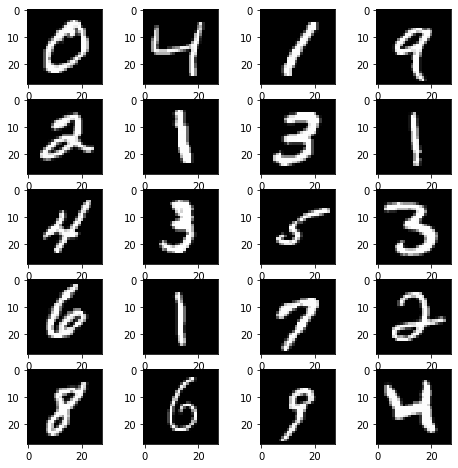

In [7]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = imagearray[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [8]:
import mxnet as mx

In [9]:
data = mx.symbol.Variable('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))

flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")

fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)

lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')


In [10]:
# mod = mx.mod.Module(lenet, context=mx.gpu(0))
mod = mx.mod.Module(lenet)

In [11]:
train_iter = mx.io.MNISTIter(shuffle=True, image="../data/train-images-idx3-ubyte", label="../data/train-labels-idx1-ubyte")
val_iter = mx.io.MNISTIter(image="../data/t10k-images-idx3-ubyte", label="../data/t10k-labels-idx1-ubyte")

In [12]:
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params(initializer=mx.init.Xavier(magnitude=2.))
mod.init_optimizer(optimizer_params=(('learning_rate', 0.1), ))
mod.fit(train_iter, num_epoch=10)

/usr/local/lib/python3.6/dist-packages/mxnet/module/base_module.py:502: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


In [13]:
metric = mx.metric.Accuracy()
mod.score(val_iter, metric)
print(metric.get())
('accuracy', 0.9654447115384616)

('accuracy', 0.9902844551282052)


('accuracy', 0.9654447115384616)

In [14]:
mod.save_checkpoint("mnist-lenet", 10)

In [15]:
! python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_mxnet.py --input_model ./mnist-lenet-0010.params --input_shape [1,1,28,28] --input_symbol ./mnist-lenet-symbol.json

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/gopher/project/./mnist-lenet-0010.params
	- Path for generated IR: 	/home/gopher/project/.
	- IR output name: 	mnist-lenet-0010
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,1,28,28]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
MXNet specific parameters:
	- Deploy-ready symbol file: 	/home/gopher/project/./mnist-lenet-symbol.json
	- Enable MXNet loader for models trained with MXNet version lower than 1.0.0: 	False
	- Prefix name for args.nd and argx.nd files: 	None
	- Pretrained model to be merged with the .nd files: 	No